# Setup 
Assuming Stan is successfully installed, to run this notebook, we will need 3 more things

1. Install the following packages:  

    -  


2. Set the working directory to the folder containing this notebook. 

3. Finally, to keep things tidy, we run the following code to load up front all the necessary libraries and setup our environment 

In [1]:
import pystan

import numpy as np
import pandas as pd

from numpy.linalg import inv,cholesky
from scipy.stats import multivariate_normal, bernoulli
from numpy.random import uniform
from scipy.special import expit

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.set_style("darkgrid")



In [2]:
# Plot Styling
color = 'salmon'
alpha = .7
bins =100
lw = 2
linestyle = '-'
linecolor = 'r'
linealpha = .8

# Introduction  

Rosiglitazone was authorized to enter the market for the treatment of Type II diabetes in the United States in 1999 and in the European Union in 2000. New data subsequently emerged about possible cardiovascular risks associated with Rosiglitazone, confirmed by a meta-analysis in Nissen and Wolski (2007), which resulted in a European suspension of the Marketing Authorisation in 2010.  This suspension included its use as a fixed dose combination with metformin or glimepiride for Type II diabetes, which had been approved in 2003 for metformin and 2006 for glimepiride.  The drug remained available in the United States, but only under a restricted-access program implemented in 2010. 

## When to approve a drug? 
Regulators focus on a few keys factors when deciding whether a drug is fit to enter the market. In the case of Rosiglitazone, for example, previous work (Phillips et al. 2013). concentrated on 11 of the drug's effects, weighing positive effects against negative effects. Clinical trials data are presented to experts and clinicians to assess the safety of the drug.
The clinical analysis of trial data is based on statistical summaries of the data, including averages, standard deviations and signifiance levels. However any dependencies between the effects are the subject of clinical judgment and rarely are included in the statistical summaries.

In this study, we address these issues by building a Bayesian model to do a full benefit-risk balance analysis of the dataset at the individual patient's level. Specifically, we construct a latent variable model to account for the whole joint distribution of the effects. This model will allow us to simulate the effect of the drug on a new patient conditioned on all the observations in the clinical trials. By quantifying the uncertainty of the effects of a drug treatment, given the available clinical trial datasets, our approach can inform whether regulators should approve a drug or not. This is done by combining clinical judgement as well samples for the model posterior using multi criteria decision analysis (MCDA) via a Bayesian decision-theoretic framework, discussed in more detail in the Application section.


## How to model the dependence between discrete and continuous observations? 
It is common in clinical trials to collect "Yes/No" data. We want to fully model this process of interrelated dependencies, incorporate the dependence between the different measurements for each person, and account for uncertainty. Furthermore, datapoints collected in clinical trials are routinely of mixed type: binary, continuous, counts, etc. The main purpose of this work is to extend the current framework so that it can incorporate interdependencies between different features, both discrete and continuous. 

Our data is organized with one subject per row and one effect per column. For example, if our clinical trial dataset records 3 effects per subject, 'Nausea' (yes/no), 'Dyspepsia' (yes/no) and 'Haemoglobin Levels' (continuous), the dataset would look like this:

|Subject ID| Group Type| Nausea | Dyspepsia | Hemoglobin Level|
|--------- | --------- | -------- | ---------|---------|
|123 | Control | 0 | 1 | 3.42|
|213 | Treatment | 0 | 1 | 4.41|
|431 | Control  | 0 | 0 | 1.12|
|224 | Control  | 0 | 1 | -0.11|
|224 | Treatment  | 1 | 1 | 2.42|

To model the effects of a drug we need a generative model for these 3 effects that also allows for dependencies between these effects. It stands to reason that the probability of a subject experiencing Nausea is not independent of the probability of experiencing Dyspepsia. To that end, we adopt a parametric generative model to learn the covariance matrix directly. 

We denote the observed data by $y$ and the parameters of the model by $\theta$. We are then interested in the posterior distribution $\pi(\theta | y)$, with which we can draw samples from the distribution of effects on future, so far unseen, patients $y'$ conditional on the observations from $f(y'|y)$ as follows: 

$$
f(y'|y) = \int f(y'|y,\theta) \pi(\theta|y) d\theta
$$
In practice we cannot analytically derive the full posterior $\pi(\theta | y)$, but we can get samples from it using _Stan_. Consequently, we can approximate the expectation of any function $h(y')$ on the future data
$$
\mathbb{E} (h (y') | y) = \int \int h(y') f(y'|y,\theta) \pi(\theta|y) d\theta dy' = \int h(y') f(y'|y) dy'
$$
using Monte Carlo.

We assume that each subject is independently and identically distributed within its group. We run inference for each group separately and get two sets of parameters, one for the treatment group and one for the placebo, also known as control group. Using the samples from the predictive distribution of each group we can produce samples for the difference between the two groups. Generally, with these posterior samples we can compute any value of interest currently used to decide whether to approve the drug. As an application, we will later show what such an evaluation function looks like and work through a complete example (see Application section). 

# Methodology

Let $Y$ be a $N\times K$ matrix where each column represents an effect and each row refers to an individual subject. This is our observations, our clinical trials dataset. In order to distinguish the treatment from placebo subjects, we will analyse the data for each group $Y^T$ and $Y^{C}$ separately. As the model for $Y^T$ and $Y^{C}$ is identical we suppress the notation into $Y$ in the remainder of this section for convenience. Recall that the important feature of the data is that each column in $Y$ may be measured on different scales, i.e. binary, count or continuous etc. The main purpose of this work is to extend the current framework so that it can incorporate inter-dependencies between different features, both discrete and continuous.

We consider the following general latent variable framework.  The idea to assign appropriate distributions on each column and apply appropriate transformations on their parameters  via user specified link functions $g_{j}(\cdot)$, so that everything is brought on the same scale. For example, let's fix our attention to the $i$-th subject for a moment. Then if the $j$-th effect is measured in the binary scale, the model can be

\begin{equation}
\label{eq:binary}
\begin{cases}
Y_{ij}\; \sim\; \text{Bernoulli}(\eta_j),\;i=1,\dots,N,\;Y_{ij} \text{ independent, for fixed } j\\
h_{j}(\eta_j) \; = \; \mu_j + Z_{ij},\\
\end{cases}
\end{equation}

where the link function can be the logit, probit or any other bijection from $[0, 1]$ to the real line. Similarly, for count data on the $j-$th column we can adopt the following model

\begin{equation}
\label{eq:counts}
\begin{cases}
Y_{ij}\; \sim\; \text{Poisson}(\eta_j),\;i=1,\dots,N,\;Y_{ij} \text{ independent, for fixed } j\\
h_{j}(\eta_j) \; = \; \mu_j + Z_{ij}. 
\end{cases}
\end{equation}

where $h_{j}(\cdot)$ could be the natural logarithm, whereas for continuous data one can simply write 

\begin{equation}
\label{eq:contain}
Y_{ij}\; = \; \mu_j + Z_{ij},\;i=1,\dots,N.\\
\end{equation}

In order to complete the model we need to define the $N\times K$ matrix $Z$. Here we use a K-variate Normal distribution $\mathcal{N}_K(\cdot)$ on each $Z_{i :}$ row, such that


\begin{equation}
\label{eq:Zdist}
Z_{i\cdot} \;\sim\; \mathcal{N}_{K}(0_{K},\Sigma),
\end{equation}

where $\Sigma$ is a $K\times K$ covariance matrix, $O_{K}$ is a row $K-$dimensional vector with zeros and $Z_{i\cdot}$ are independent for all $i$. Of course other options are available, e.g. a multivariate $t$.

In the model above the vector $\mu=(\mu_{1},\dots,\mu_K)$ represents quantities related with the mean of each effect, whereas the matrix $\Sigma$ models their covariance. Note that the variance of binary variables is non identifiable (Chib and Greenberg (1998), Talhouk, Doucet, and Murphy (2012)), so we focus on the correlation matrix instead. 

# Stan Code

For this case study we use the Bernoulli likelihood for the binary data with a logit link function. The Stan program encoding this model is the following: 

In [3]:
with open('./modelcode.stan', 'r') as file:
    print(file.read())

data{
 int<lower=0> N;
 int<lower=0> K;
 int<lower=0> Kb;
 int<lower=0> Kc;
 int<lower=0, upper=1> yb[N,Kb];
 vector[Kc] yc[N];
}

transformed data {
  matrix[Kc, Kc] I = diag_matrix(rep_vector(1, Kc));
}
parameters {
  vector[Kb] zb[N];
  cholesky_factor_corr[K] L_R;  // first continuous, then binary
  vector<lower=0>[Kc] sigma;
  vector[K] mu;
}

transformed parameters{
  matrix[N, Kb] z;
  vector[Kc] mu_c = head(mu, Kc);
  vector[Kb] mu_b = tail(mu, Kb);
  {
    matrix[Kc, Kc] L_inv = mdivide_left_tri_low(diag_pre_multiply(sigma, L_R[1:Kc, 1:Kc]), I);
    for (n in 1:N){
      vector[Kc] resid = L_inv * (yc[n] - mu_c);
      z[n,] = transpose(mu_b + tail(L_R * append_row(resid, zb[n]), Kb));
    }
  }
}

model{
  mu ~ normal(0,10);
  L_R ~ lkj_corr_cholesky(2);
  sigma~cauchy(0,2.5);
  yc ~ multi_normal_cholesky(mu_c, diag_pre_multiply(sigma, L_R[1:Kc, 1:Kc]));
  for (n in 1:N) zb[n] ~ normal(0,1);
  for (k in 1:Kb) yb[,k] ~ bernoulli_logit(z[,k]);
  
}

generated quantities{
  matr

In [4]:
with open('./modelcode.stan', 'r') as file:
    model_code = file.read()

We will fit the model with synthetic data that we generate as follows: 

In [5]:

def C_to_R(M):
    """
    Send a covariance matrix M to the corresponding
    correlation matrix R
    Inputs
    ============
    - M : covariance matrix
    Output
    ============
    - correlation matrix
    """

    d = np.asarray(M.diagonal())
    d2 = np.diag(d**(-.5))
    R = np.dot(np.dot(d2,M),d2)
    return R


def gen_data(N=400, Kb=1, Kc=2, random_seed = 234234999):
    """
    Generate data of dimension [N,Kb+Kc]
    Inputs
    ============
    - N : number of rows/subjects
    - Kb : number of binary effects
    - Kc : number of conitnuous effects
    Output
    ============
    - correlation matrix
    """
    np.random.seed(random_seed)

    N1 = N/2 # size of Group1
    N2 = N-N1 # size of Group2
    K = Kb+Kc # total number of effects

    A = np.tril(uniform(-3,3,size = (K,K)))
    C = np.dot(A,A.T)
    R = C_to_R(C)
    
    # Choose variances
    sigma = uniform(1,4,size= Kc)
    
    # Construct the covariance matrix
    D = np.diag(np.concatenate((sigma,np.ones(Kb))))  
    Sigma =  np.diag(D.dot(R).dot(D))
    
    # Means for Group 1
    mu_c = uniform(-10,10, size = Kc)
    mu_b = uniform(-1,1,size = Kb)
    mu1 = np.concatenate([mu_c,mu_b], axis=0)

    # Means for Group 2
    mu2 = mu1.copy()
    mu2[:Kc] = mu2[:Kc] + uniform(-5,5,size = Kc)
    mu2[Kc:] = mu2[Kc:] + uniform(-.5,.5,size = Kb)


    # group1
    z = multivariate_normal.rvs(mean=mu1, cov=Sigma, size=N1 )
    y1 = np.empty(z.shape)
    y1[:,Kc:] = bernoulli.rvs(p=expit(z[:,Kc:]))
    y1[:,:Kc] = z[:,:Kc]

    # group2
    z = multivariate_normal.rvs(mean=mu2, cov=Sigma, size=N2 )
    y2 = np.empty(z.shape)
    y2[:,:Kc] = z[:,:Kc]
    y2[:,Kc:] = bernoulli.rvs(p=expit(z[:,:Kb]))


    return y1,y2, mu1,mu2, R, sigma, N1,N2, Kb, Kc



It's good practice to save the data and posterior samples of the model fit to it. 
In our case, we will need it again when we demonstrate how to fit the model on the real datasets. For the purposes of this notebook, we will re-use this data in place of the hypothetical control group dataset. We can save the data and the samples as follows

In [6]:
y_control,y_treat, mu_control,mu_treat, R, sigma, N_control,N_treat, Kb, Kc = gen_data(N=400, Kb=4, Kc=2)

In [7]:
data_control = dict(N=N_control, Kb=Kb, Kc=Kc, K=Kb+Kc, yb=y_control[:,Kc:].astype(int),yc=y_control[:,:Kc])
pickle.dump(data_control, open( "data_control.pkl", "wb" ) )

data_treat = dict(N=N_treat, Kb=Kb, Kc=Kc, K=Kb+Kc, yb=y_treat[:,Kc:].astype(int),yc=y_treat[:,:Kc])
pickle.dump(data_treat, open( "data_treat.pkl", "wb" ) )

We compile the model with the following code.

In [8]:
sm = pystan.StanModel(model_code=model_code, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_347c6f238e43a7a07dd740d8cd0f121c NOW.
INFO:pystan:OS: darwin, Python: 2.7.14 |Anaconda, Inc.| (default, Oct 27 2017, 11:24:26) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], Cython 0.26.1


Compiling /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/stanfit4anon_model_347c6f238e43a7a07dd740d8cd0f121c_919997910250750045.pyx because it changed.
[1/1] Cythonizing /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/stanfit4anon_model_347c6f238e43a7a07dd740d8cd0f121c_919997910250750045.pyx
building 'stanfit4anon_model_347c6f238e43a7a07dd740d8cd0f121c_919997910250750045' extension
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var/folders
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var/folders/9j
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T
creating /var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM/var/folders/9j/qb9gcwnj2lnb77886qjkmnfm0000gn/T/tmp_NaDpM
g

We fit the model with the following code

In [9]:
fit = sm.sampling(data=data_control, iter=1000, chains=4)

We save the extracted samples to be used later again

In [10]:
post_samples = fit.extract(permuted=True)  # return a dictionary of arrays
pickle.dump(post_samples, open( "fit_control.pkl", "wb" ) )

To avoid waiting we can load the pre-fit result as follows:

In [72]:
post_samples = pickle.load( open( "fit_control.pkl", "rb" ) )

## Model Diagnostics
We see that max `Rhat` values are good, below 1.01. The effective sample size `n_eff` is good and the rest of the diagnostics are clean.
Below we plot histograms of posterior samples for the mean, correlations and variance of the effects against the true values. 

In [75]:
print(fit)

KeyboardInterrupt: 

Exception KeyboardInterrupt in 'pystan._chains.get_kept_samples' ignored


Inference for Stan model: anon_model_347c6f238e43a7a07dd740d8cd0f121c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
zb[0,0]         0.44    0.02   0.96   -1.4  -0.22   0.41   1.12   2.32 2000.0    1.0
zb[1,0]        -0.47    0.02   0.94  -2.39  -1.12  -0.44   0.17   1.31 2000.0    1.0
zb[2,0]         0.72    0.02   0.86  -0.96   0.16   0.71   1.29   2.38 2000.0    1.0
zb[3,0]         0.63    0.02   0.94  -1.34   0.04   0.63   1.24   2.46 2000.0    1.0
zb[4,0]         0.71    0.02    0.9  -1.04    0.1   0.72   1.32    2.5 2000.0    1.0
zb[5,0]        -0.28    0.02   0.92  -2.12  -0.88  -0.25   0.31   1.57 2000.0    1.0
zb[6,0]        -0.26    0.02   0.91  -2.06  -0.86  -0.26   0.34   1.55 2000.0    1.0
zb[7,0]         0.34    0.02   0.91  -1.51  -0.25   0.32   0.95   2.06 2000.0    1.0
zb[8,0]         0.37    0.02   0.89  -1.37  -0.2

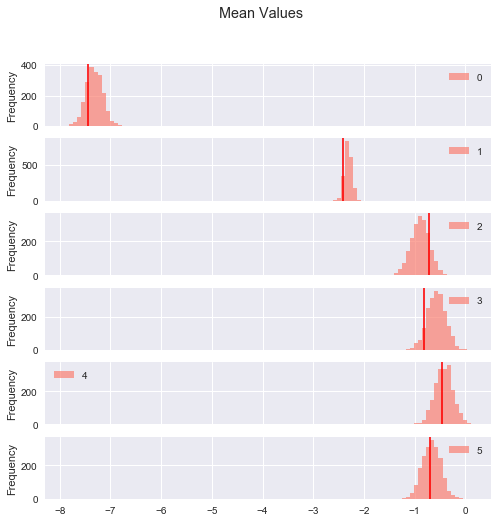

In [11]:
K = Kb+Kc
title = "Mean Values"
true_values=mu_control
df = pd.DataFrame(post_samples['mu'])
df.columns = [ str(x) for x in range(K)]


ax = df.plot.hist(subplots=True, title=title, color=color,\
                            sharex=True, sharey =False,\
                            alpha=alpha, bins=bins,\
                            figsize=(8,8));
for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);

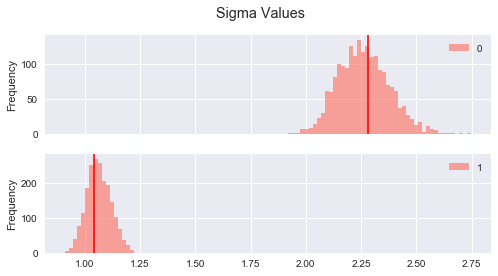

In [12]:
title = "Sigma Values"
true_values=sigma
df = pd.DataFrame(post_samples['sigma'])
df.columns = [ str(x) for x in range(Kc)]

ax = df.plot.hist(subplots=True, title=title, color=color,\
                            sharex=True, sharey =False,\
                            alpha=alpha, bins=bins,\
                            figsize=(8,4));
for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);

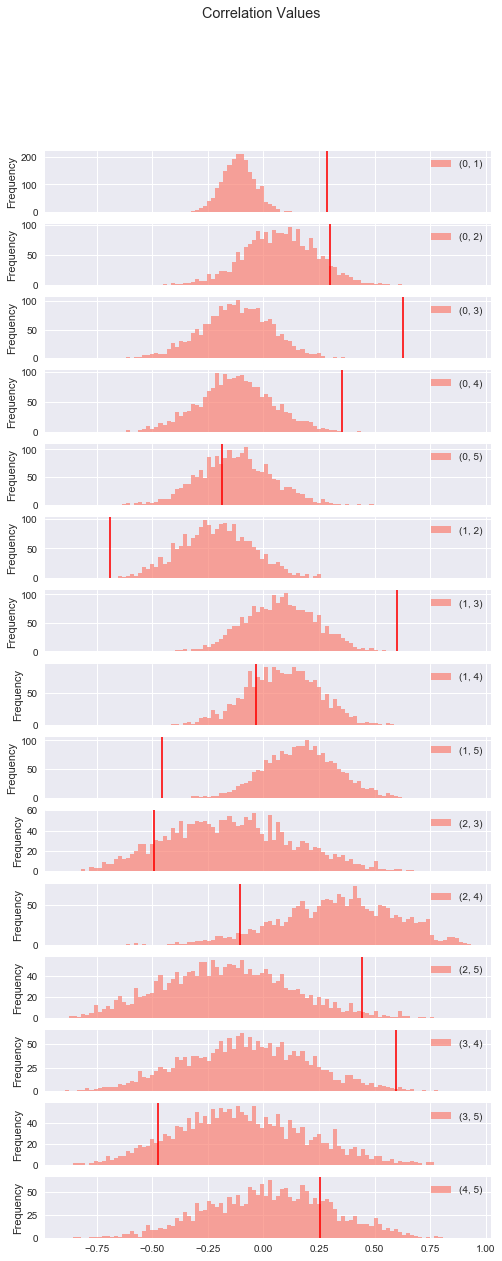

In [13]:
def flatten_corr(a):
    return a[np.triu_indices(a.shape[0], k=1)]


title = "Correlation Values"
true_values= R[np.triu_indices(R.shape[0], k=1)]



Rs = post_samples['R']
num_of_samples = Rs.shape[0]

colnames = np.array([str(x) for x in range(K)])
cnames = zip(colnames[np.triu_indices(colnames.shape[0], k=1)[0]],\
        colnames[np.triu_indices(colnames.shape[0], k=1)[1]])



M = len(cnames)
fRs = np.empty((num_of_samples,M))
for i in range (num_of_samples):
    fRs[i,:] = flatten_corr(Rs[i,:,:])

df = pd.DataFrame(fRs)
df.columns = cnames


ax = df.plot.hist(subplots=True, title=title, color=color,\
                            sharex=True, sharey =False,\
                            alpha=alpha, bins=bins,\
                            figsize=(8,20));
for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);


## Application 

In order to use the measurements in the clinical trial to make a final decision on market readiness, we need an evaluation function. Here we describe one such function that uses Multicriteria Decision Analysis (MCDA). The process of constructing such a function is somewhat involved because it requires collaboration of expertise from various fields. This section is adapted from Phillips et al. (2015).

#### How to compare disparate effects?

In order to meaningfully compare the various effects, such as glucose levels, weight loss, and cardiovascular arrest, we need to transform physical measurements to a scale appropriate to the task in hand, in this case, treating type II diabetes. For example, how are we to compare an average reduction of 5\% in Haemoglobin levels against an average 3\% increase in weight? We compare these effects and their relevant importance in a two-step process. First, we bring all measurements to a common denominator, called "preference score." Then, we ask clinicians to assign a weight to each effect based on its importance relative to the drug's treatment potential. Note that, by design, this mapping is subjective so that it can reflect the judgement of the clinicians. We leave it to the clinicians to decide whether a 1\% reduction of Haemoglobin levels outweigh the damage of 3\% increase in weight. ^[On the other hand, the mapping has to be consistent in order to be useful. Consistency is imposed through certain mathematical properties, such as all weights must sum to $1$, that in turn may impose restrictions on the clinicians' views. Hence, the way to construct such a map is some sort of interactive interrogation of clinicians. First we ask the clinicians to assign a number on the weights. Then we check where mathematical consistency breaks. With this in mind, we ask the clinicians to correct their views so that we can check again for consistency and so on, until we have reached a consistent mapping that the clinicians are satisfied with. ]


For example, one of effect for the assement of Rosiglitazone is "Nausea". For step one, we need to start from a reasonable expected range for this effect in any given trial, let's say the percentage of subjects experiencing "Nausea" ranges from 0 to 10 in percentage units (\%). The "preference score"  is essentially a map from [0,10] onto [0,100] such that 0 corresponds to the least desirable measurement, 10 \%,  and 100 the most desirable one, 0\%. With the two extremes fixed, the map can take any form in between. In this study will use linear maps for simplicity. Each effect gets it's own "preference score" map from its own range to [0,100]. This way we can track, on a common scale, how  _clinically desirable_ each observation is. In step two, each effect is given a weight $w_j$ that corresponds to the importance of moving from "preference score" 0 to 100. Finally, we need to normalize the weights to ensure they sum to 1.     


#### How to approve a drug?
With this scoring system we can estimate the effect of a drug on a new patient. For a given measurement we simply take a weighted sum of the "preference scores". Specifically for the $j$-th effect, let's assume that $c_j(\cdot)$ is the "preference score" map. Also let $y_j^{(T)}$ be the measurement in the treament group and $y_j^{(C)}$ be the corresponding measurement in the control group. We then get a final score of $$\sum_j w_j \cdot \big( c_j \big(y_j^{(T)}\big) - c_j \big(y_j^{(C)}\big) \big) $$
Thus we can decided if the treatment is beneficial (when the sum is positive), or not (the sum is negative).    

Since there is noise in the data, the final score is noisy too. With the Bayesian model suggested here, we can use our posterior samples to propagate the uncertainty to the final score. For each posterior sample of $(\mu^{(T)}, R^{(T)})$ and $(\mu^{(C)}, R^{(C)})$, we sample a new vector of measurements $y^{(T)}$ and $y^{(C)}$, and then calculate the final score for that posterior sample. Thus by aggregating the final scores from all the posterior samples, we get a posterior distribution for the final score of the treatment.   


#### A worked out example
Here we present a full example starting from the observational  data to the final score. In this example we compare the effects of 3 different treatments for type II diabetes. We will consider 4 binary effects and 2 continuous. 
Specifically, the 4 binary features are: 
 - Diarrhoea
 - Nausea/Vomiting
 - Dyspepsia
 - Oedema   

and the 2 continuous are: 
 - Difference in Haemoglobin levels from baseline (efhgba1_diff)
 - Difference in Haemoglobin levels from baseline (effpg_diff)
 
The weights, according to clinical judgment, are (8.9, 17.8, 1.8, 0.6, 59.2,11.8). This means that a full swing from the least desirable observation to the most desirable one is judged to be $\frac{8.9}{17.8}$ more important for the first effect than for the second. The following two functions allow us to calculate the preference scores for the 6 measurements we collect from each subject. Note that for the binary data we consider the probability of observing the effect.  


For example, the measurement vector $[0.2,.5,.7,.8, -3, -1.8]$ corresponds to preference score of $[80,50,30,20, 53.3, 39.3]$. The best possible measurement would correspond necessarily to a preference score of $[100,100,100,100,100,100]$, while the worst measurement would correspond to $[0,0,0,0,0,0]$. The final score, for this measurement, is the weighted sum of the preference scores, 5289.5 .



# Application 

In order to use the measurements in the clinical trial to make a final decision on market readiness, we need an evaluation function. Here we describe one such function that uses Multicriteria Decision Analysis (MCDA). The process of constructing such a function is somewhat involved because it requires collaboration of expertise from various fields. This section is adapted from @phillips15.

## How to compare disparate effects?

In order to meaningfully compare the various effects, such as glucose levels, weight loss, and cardiovascular arrest, we need to transform physical measurements to a scale appropriate to the task in hand, in this case, treating type II diabetes. For example, how are we to compare an average reduction of 5\% in Hemoglobin levels against an average 3\% increase in weight? We compare these effects and their relevant importance in a two-step process. First, we bring all measurements to a common denominator, called "preference score." Then, we ask clinicians to assign a weight to each effect based on its importance relative to the drug's treatment potential. Note that, by design, this mapping is subjective so that it can reflect the judgement of the clinicians. We leave it to the clinicians to decide whether a 1\% reduction of Hemoglobin levels outweigh the damage of 3\% increase in weight. 


For example, one of effect for the assessment of Rosiglitazone is "Nausea". For step one, we need to start from a reasonable expected range for this effect in any given trial, let's say the percentage of subjects experiencing "Nausea" ranges from 0 to 10 in percentage units (\%). The "preference score"  is essentially a map from [0,10] onto [0,100] such that 0 corresponds to the least desirable measurement, 10 \%,  and 100 the most desirable one, 0\%. With the two extremes fixed, the map can take any form in between. In this study will use linear maps for simplicity. Each effect gets it's own "preference score" map from its own range to [0,100]. This way we can track, on a common scale, how  _clinically desirable_ each observation is. In step two, each effect is given a weight $w_j$ that corresponds to the importance of moving from "preference score" 0 to 100. Finally, we need to normalize the weights to ensure they sum to 1.


## How to score a drug?
With this scoring system we can estimate the effect of a drug on a new patient. For a given measurement we simply take a weighted sum of the "preference scores". Specifically for the $j$-th effect, let's assume that $c_j(\cdot)$ is the "preference score" map. Also let $y_j^{(T)}$ be the measurement in the treatment group and $y_j^{(C)}$ be the corresponding measurement in the control group. We then get a final score of $$s = \sum_j w_j \cdot \big( c_j \big(y_j^{(T)}\big) - c_j \big(y_j^{(C)}\big) \big) $$
Thus we can decided if the treatment is beneficial (when the sum is positive), or not (the sum is negative). 

Since there is noise in the data, the final score is noisy too. With the Bayesian model suggested here, we can use our posterior samples to propagate the uncertainty to the final score. We do this for each group separately and with the posterior samples we can estimate the probability of interest, $P(s^{(T)}>s^{(T)})$ .  


## A worked out example

Here we will present a full example starting from the observational data to the final score. In this example we assess the safety of Rosiglitazone drug for type II diabetes by comparing the distribution of the final score for the treatment group (152 subjects) and the control group (150 subjects). The first four columns record four different events, Diarrhea, Nausea/Vomiting, Dyspepsia and Edema respectively. The last two columns capture Hemoglobin and Glucose levels respectively, as deviations from the baseline recorded when the subjects entered treatment. According to clinical judgment we we will assume that the clinical weights are (8.9,17.8,1.8,0.6,59.2,11.8).  This means that, to take the first two effects for example, a full swing from the least desirable observation to the most desirable one is judged to be $\frac{8.9}{1.8}$ more important for the first effect than for the second. The following two functions allow us to calculate the preference scores for a vector of measurements for these 6 effects. Note that for the binary data we consider the underlying probability of observing the effect.



In [14]:
def pref_score(x, m1, m2 , sign=-1):
    """
    map from the effect range [m1,m2] to
    the score range [0,100]. Sign = 1
    indicates higher effect meaasurements are more
    desirable, otherwise the opposite.
    """
    m = 100./float((m2-m1))
    b = m * m1
    if sign == 1:
        return -m * m1 + m*x
    else:
        return m * m2 - m*x


def get_scores_perrow(x):
    """
    Return the preference score for a row of measurements
    for only 4 binary and 2 cont
    """
    res =np.empty(6)

    res[0] = pref_score(x[0], -6.,3.,-1)
    res[1] = pref_score(x[1], -15.,7.5,-1)
    res[2] = pref_score(x[2], 0.1,.35, -1)
    res[3] = pref_score(x[3], 0.1,.25, -1)
    res[4] = pref_score(x[4], 0.1,.2, -1)
    res[5] = pref_score(x[5], 0.,.15, -1)
    return res



For example, the measurement vector (.3,0.17, .1, .14, -1.1,-2)  gets a preference score of (20, 53.3, 100, 6.7,  45.6,  42.2). The best possible measurement would correspond necessarily to a preference score of (100,100,100,100,100), while the worst measurement would correspond to (0,0,0,0,0). 

In [15]:
x = [-1.1,-2,.3,0.17, .1, .14]
get_scores_perrow(x)

array([  45.55555556,   42.22222222,   20.        ,   53.33333333,
        100.        ,    6.66666667])

The final preference score, for this measurement, is the sum of the preference scores weighted by the clinicians weights, which gives us a final score of 4505.778, as follows: 

In [16]:

def get_final_score_perrow(x, weights = None):
    """
    dot product of measurments and clinical
    weights.
    """
    scores = get_scores_perrow(x)
    if weights is None:
        weights = np.array([59.2,11.88, .9, 17.8, 1.8, 0.6 ])
    else:
        weights = weights.reshape(x.shape)
    return np.dot(scores,weights)

In [17]:
get_final_score_perrow(x)


4349.8222222222221


We are interested in the posterior distribution of the final score for a new subject in each of the groups. This way we can calculate the posterior distribution of the difference between the two groups. We do that by sampling one latent variable vector $Z$ for each posterior sample of $\mu, R, \sigma$. For each $Z$ we calculate a final score, which becomes a posterior sample for the final score. 

The function to calculate the posterior samples for the two groups is the following:


In [29]:
def final_score(post_samples, Kc=2, Kb=4, weights = None):
    """
    get final score for posterior samples
    """
    K = Kb+Kc
    N_iter = post_samples['mu'].shape[0]
    
    mus = post_samples['mu']
    sigmas = post_samples['sigma']
    Rs = post_samples['R']
    
    if weights is None:
        ws =  np.array([59.2,11.88, .9, 17.8, 1.8, 0.6 ])

    final_score = np.empty(N_iter)
    for i in range(N_iter):
        
        D = np.diag(np.concatenate((sigmas[i,:],np.ones(Kb))))  
        Sigma =  np.diag(D.dot(R).dot(D))
        z = multivariate_normal.rvs(mean= mus[i,:],  cov = Sigma)
        final_score[i] = get_final_score_perrow(z, ws)
    return final_score


We can draw posterior samples from fitting our model to the treatment group data as follows

In [21]:
data_list = dict(N=N_treat, Kb=Kb, Kc=Kc, K=Kb+Kc, yb=y_control[:,Kc:].astype(int),yc=y_treat[:,:Kc])
pickle.dump(data_list, open( "data_treat.pkl", "wb" ) )
fit = sm.sampling(data=data_list, iter=1000, chains=4)
post_samples = fit.extract(permuted=True)  # return a dictionary of arrays
pickle.dump(post_samples, open( "fit_treat.pkl", "wb" ))  #save samples for later use



We can evaluate the above function for each group separately. The value we are interested in is the difference of the final score between the treatment and the control group. We have pre-fit our models to the two groups and saved the posterior samples. We load the samples and compute the values of interest as follows:



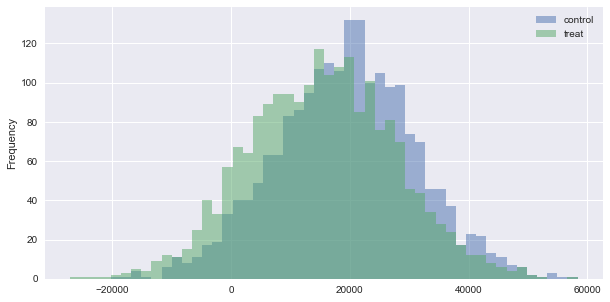

In [58]:
scores= pd.DataFrame({"control" : final_score(pickle.load( open( "fit_control.pkl", "rb" ) )),
                      "treat" : final_score(pickle.load( open( "fit_treat.pkl", "rb" ) ))})
scores.plot.hist(figsize=(10,5), alpha = .5, bins=50);


We observe that under this model, the final score is above 0 with probability 40% for a new patient. We can also make a plot of the difference to visualize the final result.

In [69]:
float((scores['diff']>0).sum())/len(scores)

0.3955

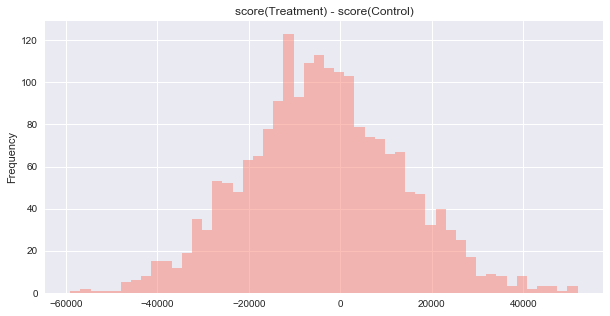

In [59]:
scores['diff'] = scores.treat -scores.control
pd.DataFrame(scores['diff']).plot.hist(figsize=(10,5), title='score(Treatment) - score(Control)',
                                                      alpha = .5, bins=50, color='salmon',
                                                     legend=False);


### Discussion - Future Work

One natural question is how sensitive is the final result to the choice of preference score functions. The preference scores could in principle have any form. In this study we chose linear mappings because they are easy to interpret and to work with. @phillips15 looked at non-linear preference functions, guided by clinical experts who suggested that “desirability” of some effects is better modeled with sigmoid-like functions. Their study found “that model results are very robust to imprecision and disagreements about weights. Even non-linear value functions on the most discriminating effects did not tip this balance [sign of score difference between treatment and control]”.

Another source of variability we examined is the choice of clinical weights. Based on preliminary experimentation we conclude that the final probability seems relatively stable to changes of the weights. When we pertrube the weights by 10% we observed a difference in the final score distribution that was close to 5%.

__Acknowledgments__   
The author would like to thank Jonah Gabry, Bob Carpenter, Andrew Gelman, and Ben Goodrich (who practically wrote the stan code) for their feedback and help during the process of writing this report.


__License__  

- Code &copy; 2017, Konstantinos Vamvourellis, licensed under BSD-3   
- Text &copy; 2017, Konstantinos Vamvourellis, licensed under CC BY-NC 4.0

# References 

 - Chib, S., and E. Greenberg. 1998. “Analysis of Multivariate Probit Models.” Biometrika 85 (2).

 - Nissen, S. E., and K. Wolski. 2007. “Effect of Rosiglitazone on the Risk of Myocardial Infarction and Death from Cardiovascular Causes.” New England Journal of Medicine 356: 2457–71.

 - Phillips, Lawrence, Billy Amzal, Alex Asiimwe, Edmond Chan, Chen Chen, Diana Hughes, Juhaeri Juhaeri, et al. 2015. “Wave 2 Case Study Report: Rosiglitazone.”

 - Phillips, Lawrence, and others. 2013. “IMI Work Package 5: Report 2:b:ii Benefit - Risk Wave 2 Case Study Report: Rosiglitazone.”

 - Talhouk, A., A. Doucet, and K. Murphy. 2012. “Efficient Bayesian Inference for Multivariate Probit Models with Sparse Inverse Correlation Matrices.” Journal of Computational and Graphical Statistics 21 (3).